In [129]:
import math
import os.path as osp
from itertools import chain
import numpy as np
import torch
import torch.nn.functional as F
from scipy.sparse.csgraph import shortest_path
from sklearn.metrics import roc_auc_score,accuracy_score
from torch.nn import BCEWithLogitsLoss, Conv1d, MaxPool1d, ModuleList
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, GCNConv, GINConv,SAGEConv,GraphConv,TransformerConv, global_sort_pool
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import k_hop_subgraph, to_scipy_sparse_matrix, from_networkx,to_networkx
import matplotlib.pyplot as plt
import pickle
import networkx as nx
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import torch_geometric.transforms as T
import random
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [130]:
file_pi = open('data/data.pkl', 'rb') 
data = pickle.load(file_pi)
graphs = data['graphs']
lab = np.array(data['labels']).reshape(-1,1)
print(len(graphs), len(lab))
scaler = MinMaxScaler()
labels = scaler.fit_transform(lab)
data_list = []
for index, g in enumerate(graphs):
    attributes = []
    nodes = list(g.nodes())
    edges = list(g.edges())
    for n in g.nodes(data = True):

        attributes.append(list(n[1].values()))

    g1 = nx.Graph()
    g1.add_nodes_from(nodes)
    g1.add_edges_from(edges)
    d = from_networkx(g1)
    attributes = np.array(attributes).astype(np.long)
    d.x = torch.tensor(attributes).float()
    y = labels[index]
    d.y = torch.tensor(y).long()
    data_list.append(d)

201 201


In [131]:
train_data = data_list[:int(len(graphs)*0.7)]
test_data = data_list[int(len(graphs)*0.7):]
len(train_data), len(test_data)

(140, 61)

In [132]:
train_data[0]

Data(edge_index=[2, 106], num_nodes=53, x=[53, 91], y=[1])

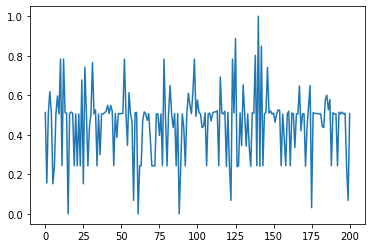

In [133]:
plt.plot(labels)

In [134]:
batch_size = 8
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [144]:
class DGCNN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers, GNN=SAGEConv, k=0.6):
        super().__init__()

        if k < 1:  # Transform percentile to number.
            num_nodes = sorted([data.num_nodes for data in train_data])
            k = num_nodes[int(math.ceil(k * len(num_nodes))) - 1]
            k = max(10, k)
        self.k = int(k)

        self.convs = ModuleList()
        self.convs.append(GNN(91, hidden_channels))
#         self.convs.append(GNN(1433, hidden_channels))
        for i in range(0, num_layers - 1):
            self.convs.append(GNN(hidden_channels, hidden_channels))
        self.convs.append(GNN(hidden_channels, 1))
        conv1d_channels = [8, 16]
        total_latent_dim = hidden_channels * num_layers + 1
        conv1d_kws = [total_latent_dim, 5]
        self.conv1 = Conv1d(1, conv1d_channels[0], conv1d_kws[0],
                            conv1d_kws[0])
        self.maxpool1d = MaxPool1d(2, 2)
        self.conv2 = Conv1d(conv1d_channels[0], conv1d_channels[1],
                            conv1d_kws[1], 1)
        dense_dim = int((self.k - 2) / 2 + 1)
        dense_dim = (dense_dim - conv1d_kws[1] + 1) * conv1d_channels[1]
        self.mlp = MLP([416, 16,1], dropout=0.5, batch_norm=False)

    def forward(self, x, edge_index, batch):
#         x_full = x
#         xs = [x[:,:1433]]
        xs = [x]
#         print(x.shape)
        for conv in self.convs:
            xs += [conv(xs[-1], edge_index).tanh()]
        x = torch.cat(xs[1:], dim=-1)
        # Global pooling.
        x = global_sort_pool(x, batch, self.k)
        x = x.unsqueeze(1)  # [num_graphs, 1, k * hidden]
        x = self.conv1(x).relu()
        x = self.maxpool1d(x)
        x = self.conv2(x).relu()
#         
        x = x.view(x.size(0), -1)  # [num_graphs, dense_dim]
#         print(x.shape, x_full[:,1433:].shape)
#         x = torch.cat((x,x_full[:,1433:]),axis=1)
        x = self.mlp(x)
        return x
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        
        loss = criterion(out.view(-1), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_data)

@torch.no_grad()
def test(loader):
    model.eval()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        logits = model(data.x, data.edge_index, data.batch)
        loss = criterion(logits.view(-1), data.y.float())
        total_loss += float(loss) * data.num_graphs
        
    return total_loss/len(test_data)


In [149]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device =torch.device('cpu')
model = DGCNN(hidden_channels=32, num_layers=3).to(device)
print(model)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001)
criterion = torch.nn.L1Loss()
train_loss, test_loss = [],[]
for epoch in range(1, 200):
    loss = train()
    tst_loss = test(test_loader)
    
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, '
          f'Test: {tst_loss:.4f}')
    train_loss.append(loss)
    test_loss.append(tst_loss)

DGCNN(
  (convs): ModuleList(
    (0): SAGEConv(91, 32)
    (1): SAGEConv(32, 32)
    (2): SAGEConv(32, 32)
    (3): SAGEConv(32, 1)
  )
  (conv1): Conv1d(1, 8, kernel_size=(97,), stride=(97,))
  (maxpool1d): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(8, 16, kernel_size=(5,), stride=(1,))
  (mlp): MLP(416, 16, 1)
)
Epoch: 01, Loss: 0.2310, Test: 0.2433
Epoch: 02, Loss: 0.2259, Test: 0.2374
Epoch: 03, Loss: 0.2190, Test: 0.2301
Epoch: 04, Loss: 0.2141, Test: 0.2219
Epoch: 05, Loss: 0.2024, Test: 0.2154
Epoch: 06, Loss: 0.1958, Test: 0.2051
Epoch: 07, Loss: 0.1882, Test: 0.2003
Epoch: 08, Loss: 0.1794, Test: 0.1935
Epoch: 09, Loss: 0.1774, Test: 0.1874
Epoch: 10, Loss: 0.1664, Test: 0.1813
Epoch: 11, Loss: 0.1567, Test: 0.1745
Epoch: 12, Loss: 0.1495, Test: 0.1679
Epoch: 13, Loss: 0.1459, Test: 0.1595
Epoch: 14, Loss: 0.1409, Test: 0.1502
Epoch: 15, Loss: 0.1268, Test: 0.1423
Epoch: 16, Loss: 0.1192, Test: 0.1322
Epoch: 17, Loss: 0.1108, 

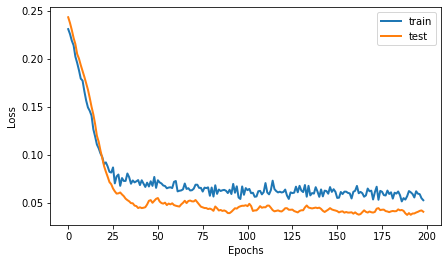

In [170]:
fig = plt.figure(figsize = (7,4))
plt.plot(train_loss,linewidth=2, label = "train")
plt.plot(test_loss,linewidth=2,label ="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_curve.pdf")
plt.show()